### ATMS 597 Project 6 Group D



<b> Set Working Directory </b>

In [1]:
#YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project6/' # Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Project6/' # Michael
YOUR_DIRECTORY = './' # David

<b> Import libraries</b>

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import seaborn as sns; sns.set(font_scale = 1.5)

## Data Processing

<b> Import Data </b>

In [3]:
gfs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Daily_PredictVars_2010thru2019.csv', index_col = 'Date', usecols = ['Date', 'TMAX', 'TMIN', 'WMAX', 'RTOT'], parse_dates = True)

hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_hourly_tidy.csv', index_col = 'Timestamp', parse_dates = True)
hourly_obs.index = hourly_obs.index + pd.DateOffset(hours=12)

daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/KCMI_daily_tidy.csv', index_col = 'Date', parse_dates = True)
daily_obs.index = daily_obs.index + pd.DateOffset(hours=12)

gfs_sfc = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Sfc_06Zto06ZAvgMinMax_AdditionalVars_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_sfc.index = gfs_sfc.index + pd.DateOffset(days=1)

gfs_prof = pd.read_csv(YOUR_DIRECTORY + 'KCMI_data/GFS_Prof_06Zto06ZAvgMinMax_2010thru2019.csv',  index_col = 'Unnamed: 0', parse_dates = True)
gfs_prof.index = gfs_prof.index + pd.DateOffset(days=1)

<b> Merge Datasets </b>

In [4]:
features = pd.merge(daily_obs.reset_index(), gfs.reset_index(), on = 'Date', how = 'inner')
features = pd.merge(features, hourly_obs.reset_index(), left_on = 'Date', right_on = 'Timestamp', how = 'inner').drop(columns = 'Timestamp')
features = pd.merge(features, gfs_sfc.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features = pd.merge(features, gfs_prof.reset_index(), how = 'inner', left_on = 'Date', right_on = 'index').drop(columns = 'index')
features.dropna(inplace = True)  # There are some NaNs in the observations

<b> Other stuff </b>

In [5]:
# Add year, month, day as integers
features['year'] = features['Date'].dt.year
features['month'] = features['Date'].dt.month
features['day'] = features['Date'].dt.day

# Filter the predictors
predictors = features.drop(columns = ['Date', 'Max Hourly Temp (C)', 'Min Hourly Temp (C)', 'Max Wind Speed (m/s)', 'Daily Precip (mm)'], axis = 1)

# For plotting
test_dates = np.array(features.query('year == 2019')['Date'])

<b> Split </b>

In [6]:
# Tmax
train_verification_tmax = np.array(features.query('year < 2019')['Max Hourly Temp (C)'])
test_verification_tmax = np.array(features.query('year == 2019')['Max Hourly Temp (C)'])

rf_tmax_vars  = ['TMAX','TMIN','tmpc','dwpc','WMAX','day','Avg DWPDEP(C)','Max DWPDEP(C)','Avg LCLD(%)','Avg HCLD(%)','Avg PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa TMPC',
                      'Min 925hPa TMPC','Max 925hPa TMPC','Min 250hPa WSPD(m/s)','Min 850hPa WSPD(m/s)']

rf_train_vars_tmax = predictors.query('year < 2019')[rf_tmax_vars] 
rf_test_vars_tmax = predictors.query('year == 2019')[rf_tmax_vars]

# Tmin 
train_verification_tmin = np.array(features.query('year < 2019')['Min Hourly Temp (C)'])
test_verification_tmin = np.array(features.query('year == 2019')['Min Hourly Temp (C)'])

rf_tmin_vars = ['TMAX','TMIN','WMAX','RTOT','mslp','wspd','skct','tmpc','dwpc','pr1h','Avg DWPDEP(C)','Avg LCLD(%)','Max LCLD(%)','Avg MCLD(%)','Avg HCLD(%)','Max HCLD(%)',
                     'Avg PRES(hPa)','Max PRES(hPa)','Avg 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)','Avg 250hPa HGT(m)','Avg 500hPa HGT(m)','Min 850hPa TMPC','Min 925hPa TMPC',
                     'Min 250hPa WSPD(m/s)','Min 925hPa WSPD(m/s)','Max 925hPa WSPD(m/s)'] 

rf_train_vars_tmin = predictors.query('year < 2019')[rf_tmin_vars] 
rf_test_vars_tmin = predictors.query('year == 2019')[rf_tmin_vars]

# Wind
train_verification_wind = np.array(features.query('year < 2019')['Max Wind Speed (m/s)'])
test_verification_wind = np.array(features.query('year == 2019')['Max Wind Speed (m/s)'])

rf_train_vars_wind = predictors.query('year < 2019').to_numpy()  # Use all available predictors
rf_test_vars_wind = predictors.query('year == 2019').to_numpy()

# Precip
train_verification_prcp = np.array(features.query('year < 2019')['Daily Precip (mm)'])
test_verification_prcp = np.array(features.query('year == 2019')['Daily Precip (mm)'])

rf_prcp_vars = ['RTOT','TMAX','TMIN','WMAX','tmpc','mslp','skct','day','Min MCLD(%)','Max MCLD(%)','Max HCLD(%)','Avg PRES(hPa)','Min 850hPa DWPDEP(C)','Max 850hPa DWPDEP(C)',
                            'Avg 500hPa HGT(m)','Max 500hPa WSPD(m/s)','Max 925hPa WSPD(m/s)','Avg 850hPa WSPD(m/s)','Avg 500hPa WSPD(m/s)','Avg 250hPa DWPDEP(C)',
                            'Avg 500hPa DWPDEP(C)','Min 500hPa DWPDEP(C)','Avg 700hPa DWPDEP(C)','Min 700hPa DWPDEP(C)','Avg 850hPa DWPDEP(C)']

rf_train_vars_prcp = predictors.query('year < 2019')[rf_prcp_vars] 
rf_test_vars_prcp = predictors.query('year == 2019')[rf_prcp_vars]

# Random Forest Regression

## Maximum Temperature

### Training Model

In [17]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmax = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmax.fit(rf_train_vars_tmax, train_verification_tmax);

### RMSE

In [17]:
rf_predictions_tmax = rfmax.predict(rf_test_vars_tmax)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmax, rf_predictions_tmax, squared = False), 2), 'degrees C.')

Root Mean Square Error: 1.92 degrees C.


### Plot

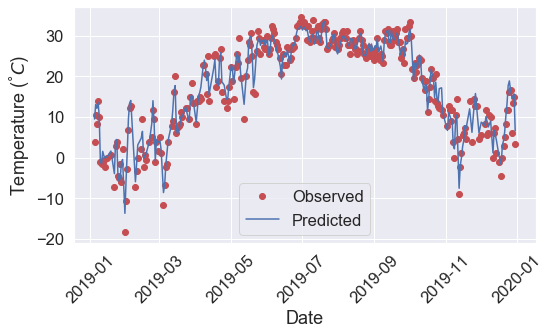

In [18]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmax, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmax, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Minimum Temperature

### Training Model

In [19]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfmin = rfmin = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfmin.fit(rf_train_vars_tmin, train_verification_tmin);

### RMSE

In [20]:
rf_predictions_tmin = rfmin.predict(rf_test_vars_tmin)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_tmin, rf_predictions_tmin, squared = False), 2), 'degrees C.')

Root Mean Square Error: 2.11 degrees C.


### Plot

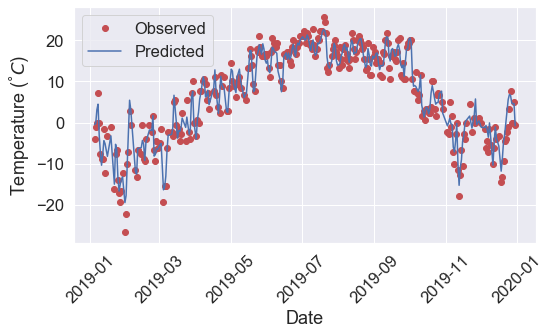

In [21]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_tmin, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_tmin, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Temperature ($^\degree C$)')
plt.xticks(rotation = 45)
plt.legend()
plt.tight_layout()
plt.show()

## Maximum Wind

### Training Model

In [22]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfwind = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'auto', min_samples_leaf = 1, min_samples_split = 3, bootstrap = True)
rfwind.fit(rf_train_vars_wind, train_verification_wind);

### RMSE

In [23]:
rf_predictions_wind = rfwind.predict(rf_test_vars_wind)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_wind, rf_predictions_wind, squared = False), 2), 'm/s.')

Root Mean Square Error: 1.69 m/s.


### Plot

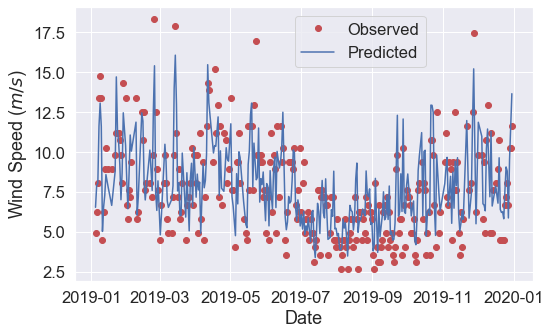

In [24]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_wind, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_wind, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Wind Speed ($m/s$)')
plt.legend(loc = [0.48, 0.78])
plt.tight_layout()
plt.show()

## Precipitation

### Training Model

In [25]:
# Fit the model. The hyper-parameters were determined prior using RandomizedSearchCV
rfprcp = RandomForestRegressor(n_estimators = 1600, random_state = 42, max_depth = 80, max_features = 'sqrt', min_samples_leaf = 8, min_samples_split = 3, bootstrap = True)
rfprcp.fit(rf_train_vars_prcp, train_verification_prcp);

### RMSE

In [26]:
rf_predictions_prcp = rfprcp.predict(rf_test_vars_prcp)
print('Root Mean Square Error:', round(mean_squared_error(test_verification_prcp, rf_predictions_prcp, squared = False), 2), 'mm.')

Root Mean Square Error: 4.18 mm.


### Plot

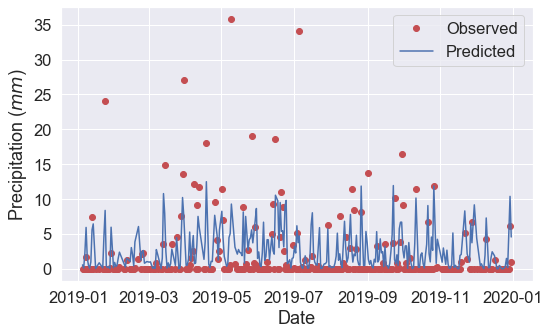

In [27]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, rf_predictions_prcp, 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

# Neural Network

<b> Import libraries </b>

In [10]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from sklearn import preprocessing

# Commonly used modules
import numpy as np
import os
import sys

# Images, plots, display, and visualization
import IPython

import datetime, os
%load_ext tensorboard
logs_base_dir = "./logs"
os.makedirs(logs_base_dir, exist_ok=True)

print(tf.__version__)

2.0.0


<b> Useful functions </b>

In [46]:
def plot_history(unit):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [' + unit + ']')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label = 'Val Error')
    plt.legend()
    plt.ylim([0,50])

## Maximum Temperature

In [8]:
rf_train_vars_tmax.head()

,TMAX,TMIN,tmpc,dwpc,WMAX,day,Avg DWPDEP(C),Max DWPDEP(C),Avg LCLD(%),Avg HCLD(%),Avg PRES(hPa),Avg 850hPa DWPDEP(C),Max 850hPa TMPC,Min 925hPa TMPC,Max 925hPa TMPC,Min 250hPa WSPD(m/s),Min 850hPa WSPD(m/s)
0,-10.16,-15.96,-13.325000,-16.933333,4.687217,2,3.530000,4.95,36.000000,0.000000,1000.722222,15.539375,-14.439245,-19.584138,-15.991250,73.887425,13.817925
1,-9.96,-14.36,-16.525000,-19.816667,5.941380,3,3.194444,4.43,3.555556,7.375000,1000.677778,19.689315,-11.294434,-15.187083,-12.670853,28.958127,9.187170
2,-8.46,-12.86,-15.325000,-19.858333,5.685068,4,2.160000,3.11,37.777778,40.222222,998.111111,11.441479,-11.160000,-14.453023,-11.653750,11.908539,16.236038
3,-7.16,-11.06,-14.441667,-17.700000,3.794733,5,1.876667,2.37,96.555556,26.777778,996.388889,10.031624,-8.604550,-12.781705,-10.715814,9.865169,18.732500
4,-5.46,-7.46,-15.133333,-18.383333,9.548298,6,1.624444,2.39,77.125000,36.666667,994.244444,14.460429,-6.668571,-10.843721,-9.252248,46.999925,5.498429


In [9]:
# Standardize
rf_train_vars_tmax_norm = preprocessing.scale(rf_train_vars_tmax)

In [10]:
rf_train_vars_tmax_norm

array([[-2.32891796, -2.30849916, -2.27732287, ..., -2.76554373,
         1.07224601,  0.20569136],
       [-2.31115791, -2.14857422, -2.54522292, ..., -2.44072711,
        -0.60705908, -0.36187575],
       [-2.17795748, -1.9986446 , -2.4447604 , ..., -2.34122941,
        -1.24431497,  0.50206671],
       ...,
       [-0.23323133, -0.20948443, -0.73271164, ..., -0.54641769,
         1.19174789, -1.06252997],
       [-0.43747197, -0.70924984, -0.9141023 , ..., -0.10771683,
         0.90899938,  2.73577866],
       [-1.27219462, -0.97912316, -0.48295066, ..., -0.23558141,
         1.94153544,  0.83527197]])

### Build Model

In [11]:
# Build Model with 1 hidden layer of 20 neurons
def build_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmax_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model 

### Train Model

In [12]:
%%time
model = build_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = model.fit(rf_train_vars_tmax_norm, train_verification_tmax, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/1000
2631/2631 [==============================] - 2s 789us/sample - loss: 417.2899 - mae: 17.8363 - mse: 417.2899 - val_loss: 400.7869 - val_mae: 17.7167 - val_mse: 400.7869
Epoch 2/1000
2631/2631 [==============================] - 0s 142us/sample - loss: 328.2991 - mae: 16.0010 - mse: 328.2991 - val_loss: 285.0662 - val_mae: 15.1733 - val_mse: 285.0662
Epoch 3/1000
2631/2631 [==============================] - 0s 185us/sample - loss: 221.0301 - mae: 13.3239 - mse: 221.0301 - val_loss: 159.1391 - val_mae: 11.5471 - val_mse: 159.1391
Epoch 4/1000
2631/2631 [==============================] - 1s 216us/sample - loss: 124.8518 - mae: 9.9864 - mse: 124.8518 - val_loss: 78.5528 - val_mae: 7.7441 - val_mse: 78.5528
Epoch 5/1000
2631/2631 [==============================] - 1s 191us/sample - loss: 76.0105 - mae: 7.3579 - mse: 76.0105 - val_loss: 54.0834 - val_mae: 6.1367 - val_mse: 54.0834
Epoch 6/1000
2631/2631 [=============================

### RMSE

In [13]:
rmse_final = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_final, 3)))

Final Root Mean Square Error on validation set: 2.077


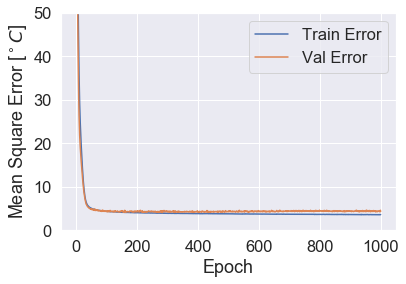

In [23]:
plot_history()

In [20]:
rf_test_vars_tmax_norm = preprocessing.scale(rf_test_vars_tmax)
mse, _, _ = model.evaluate(rf_test_vars_tmax_norm, test_verification_tmax)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

307/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Minimum Temperature

In [8]:
rf_train_vars_tmin.head()

,TMAX,TMIN,WMAX,RTOT,mslp,wspd,skct,tmpc,dwpc,pr1h,...,Max PRES(hPa),Avg 850hPa DWPDEP(C),Max 850hPa DWPDEP(C),Avg 250hPa HGT(m),Avg 500hPa HGT(m),Min 850hPa TMPC,Min 925hPa TMPC,Min 250hPa WSPD(m/s),Min 925hPa WSPD(m/s),Max 925hPa WSPD(m/s)
0,-10.16,-15.96,4.687217,0.00,1029.316667,5.591667,2.250000,-13.325000,-16.933333,0.000000,...,1002.0,15.539375,22.891972,10084.972389,5400.731226,-16.522911,-19.584138,73.887425,8.720833,28.288681
1,-9.96,-14.36,5.941380,0.06,1032.991667,4.633333,0.000000,-16.525000,-19.816667,0.000000,...,1001.8,19.689315,23.341408,10056.572290,5427.586216,-14.410704,-15.187083,28.958127,4.890000,14.984583
2,-8.46,-12.86,5.685068,0.17,1032.250000,3.641667,0.000000,-15.325000,-19.858333,0.000000,...,999.8,11.441479,17.652075,10010.796815,5392.037634,-11.718768,-14.453023,11.908539,15.286250,22.735308
3,-7.16,-11.06,3.794733,0.77,1028.141667,6.300000,1.333333,-14.441667,-17.700000,0.000000,...,997.3,10.031624,24.929242,10037.582053,5414.556603,-10.760000,-12.781705,9.865169,14.371860,20.754109
4,-5.46,-7.46,9.548298,7.10,1026.608333,5.191667,3.333333,-15.133333,-18.383333,-0.008333,...,996.0,14.460429,25.413714,10090.764166,5440.982389,-10.569524,-10.843721,46.999925,4.237442,14.102946


In [11]:
# Standardize
rf_train_vars_tmin_norm = preprocessing.scale(rf_train_vars_tmin)

In [13]:
rf_train_vars_tmin_norm

array([[-2.32891796, -2.30849916, -0.44270535, ...,  1.07224601,
        -0.33674362,  0.11453742],
       [-2.31115791, -2.14857422,  0.09056833, ..., -0.60705908,
        -0.84706671, -1.09184857],
       [-2.17795748, -1.9986446 , -0.01841627, ..., -1.24431497,
         0.53786603, -0.38903009],
       ...,
       [-0.23323133, -0.20948443,  1.93890825, ...,  1.19174789,
        -0.47028058,  1.00188642],
       [-0.43747197, -0.70924984,  0.96191022, ...,  0.90899938,
         3.41007599,  1.6955108 ],
       [-1.27219462, -0.97912316, -0.3092839 , ...,  1.94153544,
         0.85014981,  0.58586856]])

### Model

In [19]:
# Build Model with 1 hidden layer of 20 neurons
def build_tmin_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_tmin_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [22]:
%%time
tmin_model = build_tmin_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = tmin_model.fit(rf_train_vars_tmin_norm, train_verification_tmin, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/1000
2631/2631 [==============================] - 2s 714us/sample - loss: 118.5452 - mae: 9.0825 - mse: 118.5452 - val_loss: 95.3844 - val_mae: 8.2412 - val_mse: 95.3844
Epoch 2/1000
2631/2631 [==============================] - 0s 121us/sample - loss: 57.0539 - mae: 6.2881 - mse: 57.0539 - val_loss: 33.0119 - val_mae: 4.8572 - val_mse: 33.0119
Epoch 3/1000
2631/2631 [==============================] - 0s 132us/sample - loss: 23.7839 - mae: 3.9462 - mse: 23.7839 - val_loss: 15.2959 - val_mae: 3.1130 - val_mse: 15.2959
Epoch 4/1000
2631/2631 [==============================] - 0s 136us/sample - loss: 15.4529 - mae: 3.1376 - mse: 15.4529 - val_loss: 11.8660 - val_mae: 2.7477 - val_mse: 11.8660
Epoch 5/1000
2631/2631 [==============================] - 0s 154us/sample - loss: 12.2816 - mae: 2.7896 - mse: 12.2816 - val_loss: 9.7518 - val_mae: 2.4952 - val_mse: 9.7518
Epoch 6/1000
2631/2631 [==============================] - 0s 125us/sample

### RMSE

In [23]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 1.967


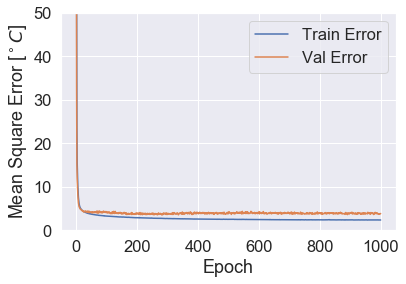

In [26]:
plot_history()

In [28]:
rf_test_vars_tmin_norm = preprocessing.scale(rf_test_vars_tmin)
mse, _, _ = tmin_model.evaluate(rf_test_vars_tmin_norm, test_verification_tmin)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

307/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Max Wind Speed

In [32]:
rf_train_vars_wind

array([[-1.01600000e+01, -1.59600000e+01,  4.68721666e+00, ...,
         2.01000000e+03,  1.00000000e+00,  2.00000000e+00],
       [-9.96000000e+00, -1.43600000e+01,  5.94138031e+00, ...,
         2.01000000e+03,  1.00000000e+00,  3.00000000e+00],
       [-8.46000000e+00, -1.28600000e+01,  5.68506816e+00, ...,
         2.01000000e+03,  1.00000000e+00,  4.00000000e+00],
       ...,
       [ 1.34400000e+01,  5.04000000e+00,  1.02883429e+01, ...,
         2.01800000e+03,  1.20000000e+01,  2.60000000e+01],
       [ 1.11400000e+01,  4.00000000e-02,  7.99061950e+00, ...,
         2.01800000e+03,  1.20000000e+01,  2.70000000e+01],
       [ 1.74000000e+00, -2.66000000e+00,  5.00099990e+00, ...,
         2.01800000e+03,  1.20000000e+01,  2.80000000e+01]])

In [30]:
# Standardize
rf_train_vars_wind_norm = preprocessing.scale(rf_train_vars_wind)

In [31]:
rf_train_vars_wind_norm

array([[-2.32891796, -2.30849916, -0.44270535, ..., -1.4602298 ,
        -1.61253656, -1.5548518 ],
       [-2.31115791, -2.14857422,  0.09056833, ..., -1.4602298 ,
        -1.61253656, -1.44113527],
       [-2.17795748, -1.9986446 , -0.01841627, ..., -1.4602298 ,
        -1.61253656, -1.32741875],
       ...,
       [-0.23323133, -0.20948443,  1.93890825, ...,  1.60626589,
         1.62118287,  1.17434479],
       [-0.43747197, -0.70924984,  0.96191022, ...,  1.60626589,
         1.62118287,  1.28806132],
       [-1.27219462, -0.97912316, -0.3092839 , ...,  1.60626589,
         1.62118287,  1.40177784]])

### Model

In [33]:
# Build Model with 1 hidden layer of 20 neurons
def build_wind_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_wind_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [34]:
%%time
wind_model = build_wind_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = wind_model.fit(rf_train_vars_wind_norm, train_verification_wind, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/1000
2631/2631 [==============================] - 2s 880us/sample - loss: 33.3305 - mae: 4.9980 - mse: 33.3305 - val_loss: 13.0970 - val_mae: 2.8225 - val_mse: 13.0970
Epoch 2/1000
2631/2631 [==============================] - 0s 187us/sample - loss: 11.9371 - mae: 2.7766 - mse: 11.9371 - val_loss: 8.1367 - val_mae: 2.2195 - val_mse: 8.1367
Epoch 3/1000
2631/2631 [==============================] - 0s 142us/sample - loss: 8.1289 - mae: 2.2845 - mse: 8.1289 - val_loss: 6.4232 - val_mae: 1.9315 - val_mse: 6.4232
Epoch 4/1000
2631/2631 [==============================] - 0s 184us/sample - loss: 6.2671 - mae: 1.9968 - mse: 6.2671 - val_loss: 5.7359 - val_mae: 1.8042 - val_mse: 5.7359
Epoch 5/1000
2631/2631 [==============================] - 1s 203us/sample - loss: 5.1809 - mae: 1.8101 - mse: 5.1809 - val_loss: 5.1818 - val_mae: 1.6966 - val_mse: 5.1818
Epoch 6/1000
2631/2631 [==============================] - 1s 207us/sample - loss: 4.525

### RMSE

In [35]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 1.769


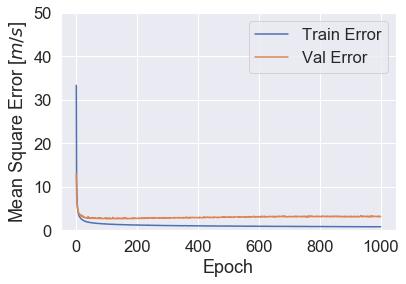

In [48]:
plot_history('$m/s$')

In [37]:
rf_test_vars_wind_norm = preprocessing.scale(rf_test_vars_wind)
mse, _, _ = wind_model.evaluate(rf_test_vars_wind_norm, test_verification_wind)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

307/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

## Total Precipitation

In [38]:
rf_train_vars_prcp.head()

,RTOT,TMAX,TMIN,WMAX,tmpc,mslp,skct,day,Min MCLD(%),Max MCLD(%),...,Max 500hPa WSPD(m/s),Max 925hPa WSPD(m/s),Avg 850hPa WSPD(m/s),Avg 500hPa WSPD(m/s),Avg 250hPa DWPDEP(C),Avg 500hPa DWPDEP(C),Min 500hPa DWPDEP(C),Avg 700hPa DWPDEP(C),Min 700hPa DWPDEP(C),Avg 850hPa DWPDEP(C)
0,0.00,-10.16,-15.96,4.687217,-13.325000,1029.316667,2.250000,2,0.0,1.0,...,81.098451,28.288681,23.064628,71.364032,12.923575,22.132323,12.601770,25.793559,17.745552,15.539375
1,0.06,-9.96,-14.36,5.941380,-16.525000,1032.991667,0.000000,3,0.0,1.0,...,53.195702,14.984583,14.311850,44.387013,13.530215,10.528838,7.183483,28.465952,16.835678,19.689315
2,0.17,-8.46,-12.86,5.685068,-15.325000,1032.250000,0.000000,4,0.0,96.0,...,35.140197,22.735308,19.625230,25.397043,12.685044,10.415984,3.023898,7.769617,2.909177,11.441479
3,0.77,-7.16,-11.06,3.794733,-14.441667,1028.141667,1.333333,5,0.0,67.0,...,28.346544,20.754109,19.975509,23.702333,8.908692,11.261288,3.546582,10.463400,3.958006,10.031624
4,7.10,-5.46,-7.46,9.548298,-15.133333,1026.608333,3.333333,6,0.0,100.0,...,44.823732,14.102946,12.570186,35.073703,7.681385,10.312995,2.920655,13.015104,1.089298,14.460429


In [39]:
# Standardize
rf_train_vars_prcp_norm = preprocessing.scale(rf_train_vars_prcp)

In [40]:
rf_train_vars_prcp_norm

array([[-0.46509258, -2.32891796, -2.30849916, ...,  1.52496059,
         1.79890333,  0.96575738],
       [-0.45659356, -2.31115791, -2.14857422, ...,  1.86209646,
         1.66155774,  1.59753526],
       [-0.44101203, -2.17795748, -1.9986446 , ..., -0.74885119,
        -0.44064974,  0.34190254],
       ...,
       [ 0.9429114 , -0.23323133, -0.20948443, ..., -0.17088529,
        -0.64149051,  0.08255837],
       [-0.43959552, -0.43747197, -0.70924984, ..., -0.05455181,
        -0.84780538, -1.17994507],
       [-0.46509258, -1.27219462, -0.97912316, ...,  1.03412771,
         1.74979727, -0.73029968]])

### Model

In [53]:
# Build Model with 1 hidden layer of 20 neurons
def build_prcp_model():
    model = keras.Sequential([
      Dense(20, activation=tf.nn.relu, input_shape=[len(rf_train_vars_prcp_norm[0])]),
        Dense(1)
    ])

    model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False), # there are others: https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers
                  loss='mse', metrics=['mae', 'mse']) 

    return model

In [54]:
%%time
prcp_model = build_prcp_model()

logdir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

history = prcp_model.fit(rf_train_vars_prcp_norm, train_verification_prcp, epochs=1000, validation_split = 0.1, callbacks=[tensorboard_callback])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

Train on 2631 samples, validate on 293 samples
Epoch 1/1000
2631/2631 [==============================] - 1s 528us/sample - loss: 40.2310 - mae: 2.5521 - mse: 40.2310 - val_loss: 58.6012 - val_mae: 2.8337 - val_mse: 58.6012
Epoch 2/1000
2631/2631 [==============================] - 0s 115us/sample - loss: 35.0154 - mae: 2.3265 - mse: 35.0154 - val_loss: 51.4825 - val_mae: 2.9079 - val_mse: 51.4825
Epoch 3/1000
2631/2631 [==============================] - 0s 120us/sample - loss: 31.3760 - mae: 2.5108 - mse: 31.3760 - val_loss: 46.6735 - val_mae: 3.1100 - val_mse: 46.6735
Epoch 4/1000
2631/2631 [==============================] - 0s 140us/sample - loss: 29.6448 - mae: 2.6390 - mse: 29.6448 - val_loss: 45.0206 - val_mae: 3.2105 - val_mse: 45.0206
Epoch 5/1000
2631/2631 [==============================] - 0s 119us/sample - loss: 29.1335 - mae: 2.7000 - mse: 29.1335 - val_loss: 44.4929 - val_mae: 3.1768 - val_mse: 44.4929
Epoch 6/1000
2631/2631 [==============================] - 0s 140us/sample

### RMSE

In [55]:
rmse_train = np.sqrt(float(hist['val_mse'].tail(1)))
print('Final Root Mean Square Error on validation set: {}'.format(round(rmse_train, 3)))

Final Root Mean Square Error on validation set: 6.673


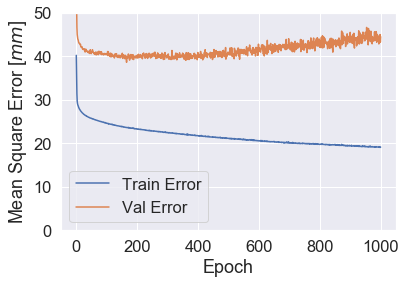

In [56]:
plot_history('$mm$')

In [57]:
rf_test_vars_prcp_norm = preprocessing.scale(rf_test_vars_prcp)
mse, _, _ = prcp_model.evaluate(rf_test_vars_prcp_norm, test_verification_prcp)
rmse = np.sqrt(mse)
print('Root Mean Square Error on test set: {}'.format(round(rmse, 3)))

307/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

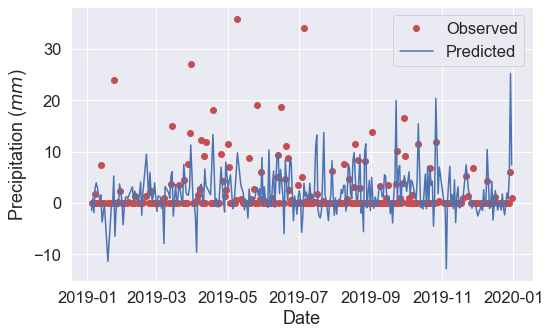

In [59]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(test_dates, test_verification_prcp, 'ro', label = 'Observed')
ax.plot(test_dates, prcp_model.predict(rf_test_vars_prcp_norm), 'b-', label = 'Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation ($mm$)')
plt.legend(loc = 'upper right')
plt.tight_layout()
plt.show()